In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from catalyst import dl, metrics
from catalyst.contrib.losses import DiceLoss, IoULoss
from catalyst.contrib.optimizers import AdamP, Lamb

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve

import datetime
import random

import sys
import os
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "datasets"))

from InriaImagesDataset import ImagesDataset
from SegmentationCustomRunner import SegmentationCustomRunner

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_DIR = os.path.join(os.path.abspath('..'), 'data', 'PreprocessedAerialImageDataset')

TRAIN_DIR = os.path.join(DATA_DIR, 'train')

today = datetime.datetime.now()

# Загрузка данных

In [3]:
df_all = pd.read_csv(os.path.join(TRAIN_DIR, 'labels.csv'))
df_all

,image,mask
0,images/austin10_image_0.jpg,gt/austin10_mask_0.png
1,images/austin10_image_1.jpg,gt/austin10_mask_1.png
2,images/austin10_image_10.jpg,gt/austin10_mask_10.png
3,images/austin10_image_11.jpg,gt/austin10_mask_11.png
4,images/austin10_image_12.jpg,gt/austin10_mask_12.png
...,...,...
17995,images/vienna9_image_95.jpg,gt/vienna9_mask_95.png
17996,images/vienna9_image_96.jpg,gt/vienna9_mask_96.png
17997,images/vienna9_image_97.jpg,gt/vienna9_mask_97.png
17998,images/vienna9_image_98.jpg,gt/vienna9_mask_98.png


In [4]:
X, y = df_all['image'], df_all['mask']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

In [5]:
df_train, df_valid = pd.concat([X_train, y_train], axis=1), pd.concat([X_valid, y_valid], axis=1)

In [6]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(),
        A.RGBShift(),
        A.Blur(),
        A.GaussNoise(var_limit=3),
        A.ElasticTransform(),
        A.MaskDropout((1, 10), p=0.5),
        ToTensorV2()
    ],
    is_check_shapes=False
)

val_transform = A.Compose(
    [   
        A.Resize(256, 256),
        ToTensorV2()
    ],
    is_check_shapes=False
)

In [7]:
ds_train = ImagesDataset(df_train, TRAIN_DIR, transform=train_transform)
ds_val = ImagesDataset(df_valid, TRAIN_DIR, transform=val_transform)

In [8]:
ds_train[0]['image'].unique()

tensor([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 2

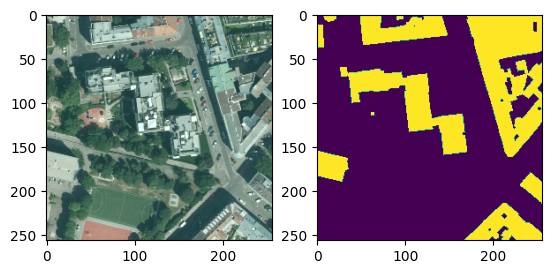

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ds_train[0]['image'].permute(1, 2, 0))
ax[1].imshow(ds_train[0]['mask'].squeeze())

In [10]:
loaders = {"train": DataLoader(ds_train, batch_size=8), 'valid': DataLoader(ds_val, batch_size=16)}

# Подготовка к обучению модели

In [11]:
#model = smp.Unet(encoder_name='efficientnet-b0', aux_params=aux_params).to(DEVICE)
#model = smp.Unet(encoder_name='efficientnet-b0').to(DEVICE)
#encoder_name = 'timm-mobilenetv3_small_075'
#encoder_name = 'tu-maxvit_rmlp_pico_rw_256'
encoder_name = 'vgg11'
model = smp.Unet(encoder_name=encoder_name, activation='sigmoid', classes=1).to(DEVICE)
model

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\MZ/.cache\torch\hub\checkpoints\vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:27<00:00, 19.2MB/s] 


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel

In [12]:
criterion = IoULoss()
#criterion = DiceLoss()
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

In [13]:
optimizer = {
    "classification": torch.optim.Adam(model.parameters(), lr=1e-4),
    #"classification": Lamb(model.parameters(), lr=1e-3)
}

In [14]:
runner = SegmentationCustomRunner(input_key="image", output_key="mask_pred", target_key="mask_target", loss_key="loss")
#runner = CustomRunner()

# Обучение модели

In [15]:
EXP_NAME = f"{encoder_name}-{today.strftime('%d-%m-%Y')}-augmentations"

In [16]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    engine=dl.GPUEngine("cuda:0"),
    loaders=loaders,
    callbacks=[
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
        dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
        dl.TrevskyCallback(input_key="mask_pred", target_key="mask_target", alpha=0.2),
        dl.PrecisionRecallF1SupportCallback(
            input_key="label_pred", target_key="label_target", num_classes=1
        ),
        dl.OptimizerCallback(
            optimizer_key="classification",
            metric_key="loss",
        ),
    ],
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False,
    num_epochs=5,
    verbose=True,
    logdir=f"./logs/{EXP_NAME}",
    load_best_on_end=True
)

1/5 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (1/5) dice: 0.5748145580291748 | dice/_macro: 0.5748145580291748 | dice/_micro: 0.5748145580291748 | f1/_macro: 0.932672297498651 | f1/_micro: 0.932672297498651 | f1/_weighted: 0.932672297498651 | iou: 0.403326153755188 | iou/_macro: 0.403326153755188 | iou/_micro: 0.403326153755188 | loss: 0.5413640168331296 | loss/mean: 0.5413640168331296 | loss/std: 0.15581793534048777 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9632943209846603 | precision/_micro: 0.9632943209846603 | precision/_weighted: 0.9632943209846603 | recall/_macro: 0.903946553692733 | recall/_micro: 0.903946553692733 | recall/_weighted: 0.903946553692733 | trevsky: 0.5061935782432556 | trevsky/_macro: 0.5061935782432556 | trevsky/_micro: 0.5061935782432556


d:\housing-segmentation-in-amur-river-area\env\lib\site-packages\accelerate\utils\dataclasses.py:522: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


1/5 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (1/5) dice: 0.7874979376792908 | dice/_macro: 0.7874979376792908 | dice/_micro: 0.7874979376792908 | f1/_macro: 0.9607816992542023 | f1/_micro: 0.9607816992542023 | f1/_weighted: 0.9607816992542023 | iou: 0.6494817733764648 | iou/_macro: 0.6494817733764648 | iou/_micro: 0.6494817733764648 | loss: 0.353469378789266 | loss/mean: 0.353469378789266 | loss/std: 0.04669926209512583 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9635397677450668 | precision/_micro: 0.9635397677450668 | precision/_weighted: 0.9635397677450668 | recall/_macro: 0.9580493181856445 | recall/_micro: 0.9580493181856445 | recall/_weighted: 0.9580493181856445 | trevsky: 0.7785719633102417 | trevsky/_macro: 0.7785719633102417 | trevsky/_micro: 0.7785719633102417
* Epoch (1/5) 


2/5 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (2/5) dice: 0.7507145404815674 | dice/_macro: 0.7507145404815674 | dice/_micro: 0.7507145404815674 | f1/_macro: 0.9657230345697868 | f1/_micro: 0.9657230345697868 | f1/_weighted: 0.9657230345697868 | iou: 0.6009151339530945 | iou/_macro: 0.6009151339530945 | iou/_micro: 0.6009151339530945 | loss: 0.4069288109496783 | loss/mean: 0.4069288109496783 | loss/std: 0.09510255348161695 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9655818733210868 | precision/_micro: 0.9655818733210868 | precision/_weighted: 0.9655818733210868 | recall/_macro: 0.9658742400223624 | recall/_micro: 0.9658742400223624 | recall/_weighted: 0.9658742400223624 | trevsky: 0.7499025464057922 | trevsky/_macro: 0.7499025464057922 | trevsky/_micro: 0.7499025464057922


2/5 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (2/5) dice: 0.8050462007522583 | dice/_macro: 0.8050462007522583 | dice/_micro: 0.8050462007522583 | f1/_macro: 0.9643666313501872 | f1/_micro: 0.9643666313501872 | f1/_weighted: 0.9643666313501872 | iou: 0.6737048029899597 | iou/_macro: 0.6737048029899597 | iou/_micro: 0.6737048029899597 | loss: 0.3284522781901891 | loss/mean: 0.3284522781901891 | loss/std: 0.04350152119164248 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9637084330092376 | precision/_micro: 0.9637084330092376 | precision/_weighted: 0.9637084330092376 | recall/_macro: 0.96503574305375 | recall/_micro: 0.96503574305375 | recall/_weighted: 0.96503574305375 | trevsky: 0.8063825368881226 | trevsky/_macro: 0.8063825368881226 | trevsky/_micro: 0.8063825368881226
* Epoch (2/5) 


3/5 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (3/5) dice: 0.7756539583206177 | dice/_macro: 0.7756539583206177 | dice/_micro: 0.7756539583206177 | f1/_macro: 0.9690412632581514 | f1/_micro: 0.9690412632581514 | f1/_weighted: 0.9690412632581514 | iou: 0.6335250735282898 | iou/_macro: 0.6335250735282898 | iou/_micro: 0.6335250735282898 | loss: 0.37416503222783437 | loss/mean: 0.37416503222783437 | loss/std: 0.09018238108551395 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9688022188982316 | precision/_micro: 0.9688022188982316 | precision/_weighted: 0.9688022188982316 | recall/_macro: 0.9692904305478939 | recall/_micro: 0.9692904305478939 | recall/_weighted: 0.9692904305478939 | trevsky: 0.7760742902755737 | trevsky/_macro: 0.7760742902755737 | trevsky/_micro: 0.7760742902755737


3/5 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (3/5) dice: 0.8190690875053406 | dice/_macro: 0.8190690875053406 | dice/_micro: 0.8190690875053406 | f1/_macro: 0.9662387752446214 | f1/_micro: 0.9662387752446214 | f1/_weighted: 0.9662387752446214 | iou: 0.6935792565345764 | iou/_macro: 0.6935792565345764 | iou/_micro: 0.6935792565345764 | loss: 0.308265662405226 | loss/mean: 0.308265662405226 | loss/std: 0.04355603018945427 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9683598441700627 | precision/_micro: 0.9683598441700627 | precision/_weighted: 0.9683598441700627 | recall/_macro: 0.9641369341620709 | recall/_micro: 0.9641369341620709 | recall/_weighted: 0.9641369341620709 | trevsky: 0.8132718801498413 | trevsky/_macro: 0.8132718801498413 | trevsky/_micro: 0.8132718801498413
* Epoch (3/5) 


4/5 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (4/5) dice: 0.7894880771636963 | dice/_macro: 0.7894880771636963 | dice/_micro: 0.7894880771636963 | f1/_macro: 0.9707807902028703 | f1/_micro: 0.9707807902028703 | f1/_weighted: 0.9707807902028703 | iou: 0.6521934866905212 | iou/_macro: 0.6521934866905212 | iou/_micro: 0.6521934866905212 | loss: 0.3551837875048323 | loss/mean: 0.3551837875048323 | loss/std: 0.08381552558063667 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9712056671731818 | precision/_micro: 0.9712056671731818 | precision/_weighted: 0.9712056671731818 | recall/_macro: 0.9703662760693826 | recall/_micro: 0.9703662760693826 | recall/_weighted: 0.9703662760693826 | trevsky: 0.7878596782684326 | trevsky/_macro: 0.7878596782684326 | trevsky/_micro: 0.7878596782684326


4/5 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (4/5) dice: 0.8297646045684814 | dice/_macro: 0.8297646045684814 | dice/_micro: 0.8297646045684814 | f1/_macro: 0.9671252904454926 | f1/_micro: 0.9671252904454926 | f1/_weighted: 0.9671252904454926 | iou: 0.7090579271316528 | iou/_macro: 0.7090579271316528 | iou/_micro: 0.7090579271316528 | loss: 0.2928181894090442 | loss/mean: 0.2928181894090442 | loss/std: 0.04200810672712568 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9744786164265469 | precision/_micro: 0.9744786164265469 | precision/_weighted: 0.9744786164265469 | recall/_macro: 0.9598919585833736 | recall/_micro: 0.9598919585833736 | recall/_weighted: 0.9598919585833736 | trevsky: 0.8107938766479492 | trevsky/_macro: 0.8107938766479492 | trevsky/_micro: 0.8107938766479492
* Epoch (4/5) 


5/5 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (5/5) dice: 0.7954190969467163 | dice/_macro: 0.7954190969467163 | dice/_micro: 0.7954190969467163 | f1/_macro: 0.9714838908963115 | f1/_micro: 0.9714838908963115 | f1/_weighted: 0.9714838908963115 | iou: 0.6603285074234009 | iou/_macro: 0.6603285074234009 | iou/_micro: 0.6603285074234009 | loss: 0.3475070563598914 | loss/mean: 0.3475070563598914 | loss/std: 0.08255950719744769 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9721017548999518 | precision/_micro: 0.9721017548999518 | precision/_weighted: 0.9721017548999518 | recall/_macro: 0.9708767991137301 | recall/_micro: 0.9708767991137301 | recall/_weighted: 0.9708767991137301 | trevsky: 0.7932190299034119 | trevsky/_macro: 0.7932190299034119 | trevsky/_micro: 0.7932190299034119


5/5 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (5/5) dice: 0.8320378065109253 | dice/_macro: 0.8320378065109253 | dice/_micro: 0.8320378065109253 | f1/_macro: 0.9675019109456925 | f1/_micro: 0.9675019109456925 | f1/_weighted: 0.9675019109456925 | iou: 0.7123841643333435 | iou/_macro: 0.7123841643333435 | iou/_micro: 0.7123841643333435 | loss: 0.2900764042006594 | loss/mean: 0.2900764042006594 | loss/std: 0.04330378797413446 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.975059862127288 | precision/_micro: 0.975059862127288 | precision/_weighted: 0.975059862127288 | recall/_macro: 0.9600700721442694 | recall/_micro: 0.9600700721442694 | recall/_weighted: 0.9600700721442694 | trevsky: 0.8125953078269958 | trevsky/_macro: 0.8125953078269958 | trevsky/_micro: 0.8125953078269958
* Epoch (5/5) 
Top models:
./logs/vgg11-02-10-2024-augmentations\checkpoints/model.0005.pth	0.7124


In [17]:
print("Best model metrics:")
print("-"*50)
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[
        dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
        dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
    ]
)

Best model metrics:
--------------------------------------------------
valid (1/1) dice: 0.8320378065109253 | dice/_macro: 0.8320378065109253 | dice/_micro: 0.8320378065109253 | iou: 0.7123841643333435 | iou/_macro: 0.7123841643333435 | iou/_micro: 0.7123841643333435
* Epoch (1/1) 


# Тестирование модели

In [18]:
def inference_one_image(image, model, transform):
    image_tensor = image.astype(np.float32)
    #image_tensor = torch.tensor(image_tensor, device=DEVICE).permute(2, 0, 1).unsqueeze(0)
    if transform:
        augmented = transform(image=image_tensor)
        image_tensor = augmented['image'].to(DEVICE).unsqueeze(0)
    else:
        image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    model.eval()
    result_mask = model(image_tensor)
    result_mask = result_mask.squeeze().detach().cpu().numpy()
    #result_mask = (result_mask > 0.5).astype(np.int_)
    #result_label = result_label.squeeze().detach().cpu().numpy()
    return result_mask

In [19]:
test_image = cv2.imread(r'..\data\PreprocessedAerialImageDataset\train\images\austin1_image_0.png')
#test_image = cv2.resize(test_image, (512, 512))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

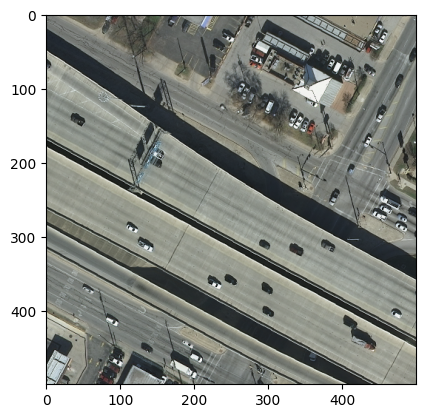

In [20]:
plt.imshow(test_image)

In [21]:
test_result = inference_one_image(test_image, model, val_transform)
test_result

array([[1.52703840e-03, 2.18858040e-04, 6.50921938e-05, ...,
        3.21153948e-06, 6.61964223e-05, 5.55390818e-03],
       [1.19704804e-04, 8.28944394e-07, 1.02119479e-07, ...,
        3.88969357e-10, 6.42747651e-08, 2.00311013e-04],
       [2.70903001e-05, 1.11768287e-07, 4.63791450e-09, ...,
        6.11466216e-12, 1.67034520e-09, 1.74644265e-05],
       ...,
       [9.96211052e-01, 9.99850035e-01, 9.99974012e-01, ...,
        4.59267646e-09, 4.21788009e-08, 3.46733505e-05],
       [9.85746622e-01, 9.99311328e-01, 9.99718964e-01, ...,
        1.18081921e-07, 7.16285001e-07, 1.18921824e-04],
       [8.93027306e-01, 9.85564530e-01, 9.89880562e-01, ...,
        3.80334750e-05, 9.12772739e-05, 3.22773145e-03]], dtype=float32)

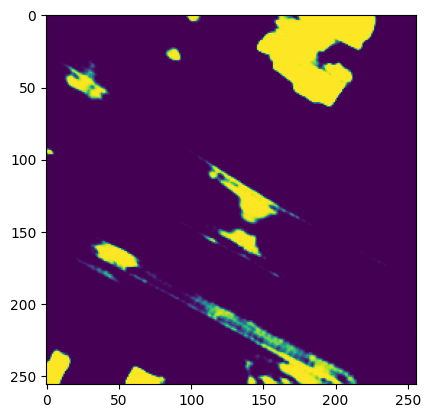

In [22]:
plt.imshow(test_result)

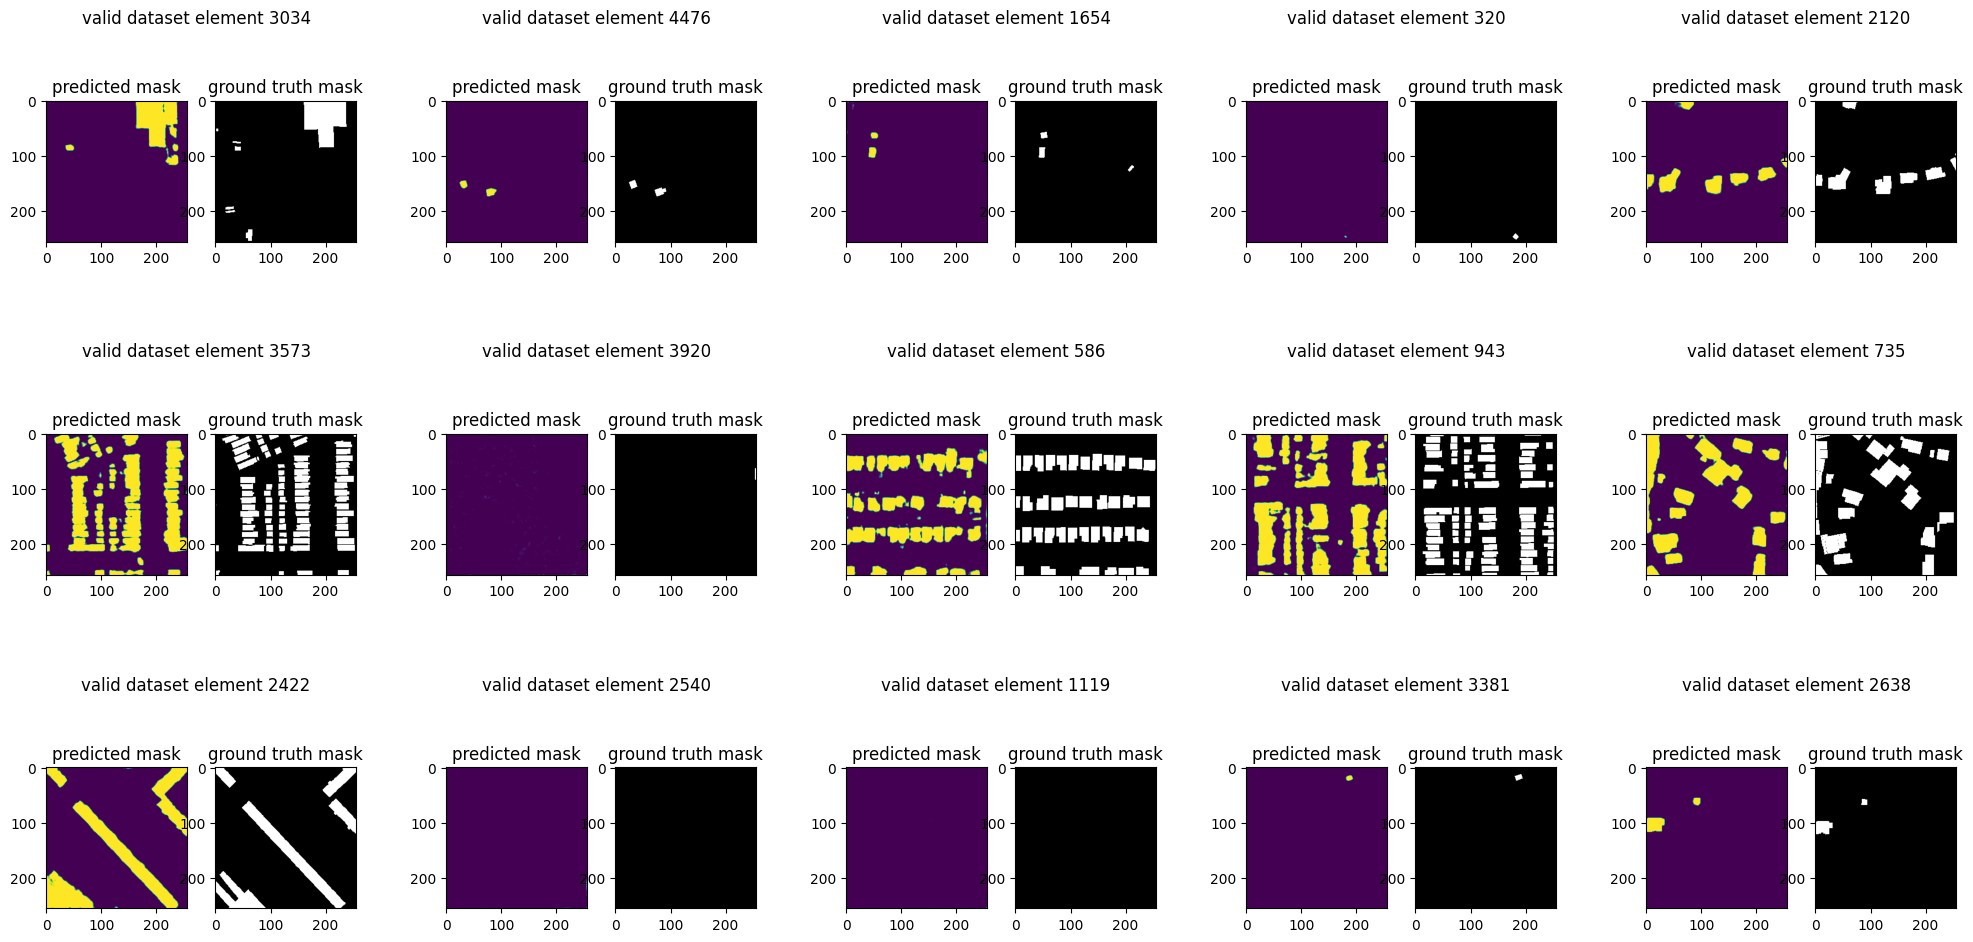

In [23]:
num_images = 15
valid_subset_numbers = random.sample(range(0, len(ds_val)), num_images)

fig = plt.figure(figsize=(20, 10))
subfigs = fig.subfigures(num_images // 5, 5)

i = 0
for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(1, 2)
    image, mask = ds_val[valid_subset_numbers[i]]['image'], ds_val[valid_subset_numbers[i]]['mask']
    subfig.suptitle(f'valid dataset element {valid_subset_numbers[i]}')

    mask_pred = model(image.to(DEVICE).float().unsqueeze(0)).detach().cpu().squeeze()
    axs[0].imshow(mask_pred)
    axs[0].set_title(f'predicted mask')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'ground truth mask')
    i += 1
plt.show()